In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np
import os
import librosa
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import joblib
import seaborn as sns
import pyaudio
import wave
import speech_recognition as sr
import time
import warnings

Yüklenen dosya sayısı: 1326
Yüklenen etiket sayısı: 1326
MFCC özellik sayısı: 1326
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Accuracy: 0.9924812030075187
F1 Score: 0.9924773434718357
Classification Report:
               precision    recall  f1-score   support

         ali       0.99      1.00      0.99        70
         can       0.99      1.00      0.99        71
       melih       1.00      0.98      0.99        61
       ozlem       1.00      0.98      0.99        64

    accuracy                           0.99       266
   macro avg       0.99      0.99      0.99       266
weighted avg       0.99      0.99      0.99       266

Processing first file in Ahmet: C:/Users/moonm/OneDrive/Masaüstü/seslerimiz/karışıkLüks/Ahmet\ahmet_cut_15sec_0.wav


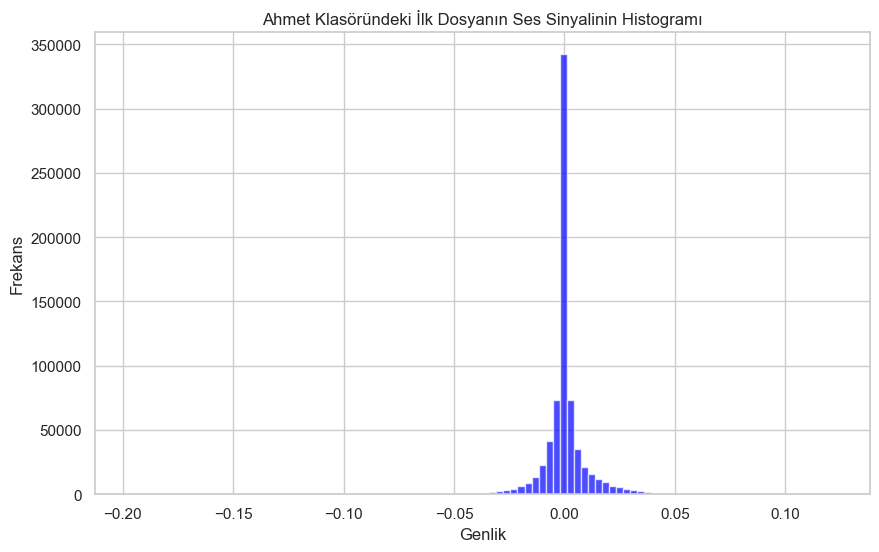

Processing first file in Ali: C:/Users/moonm/OneDrive/Masaüstü/seslerimiz/karışıkLüks/Ali\ali.wav


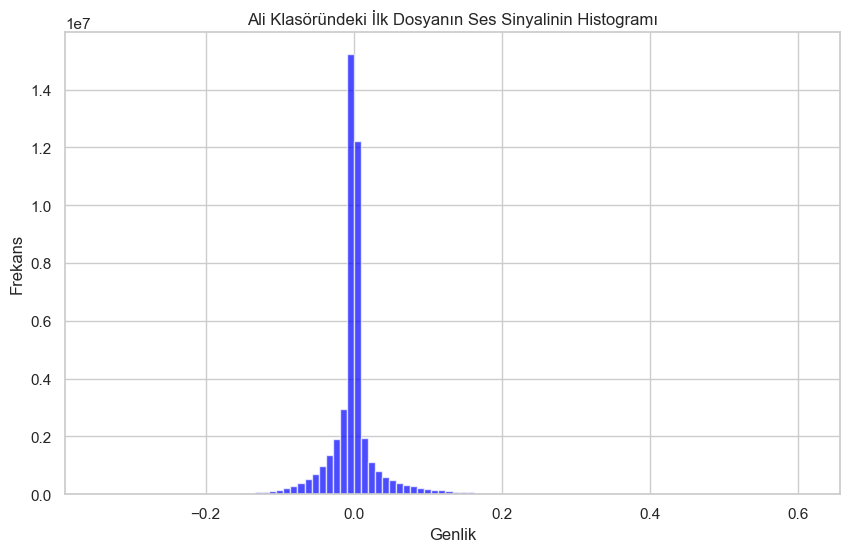

Processing first file in Can: C:/Users/moonm/OneDrive/Masaüstü/seslerimiz/karışıkLüks/Can\can.wav


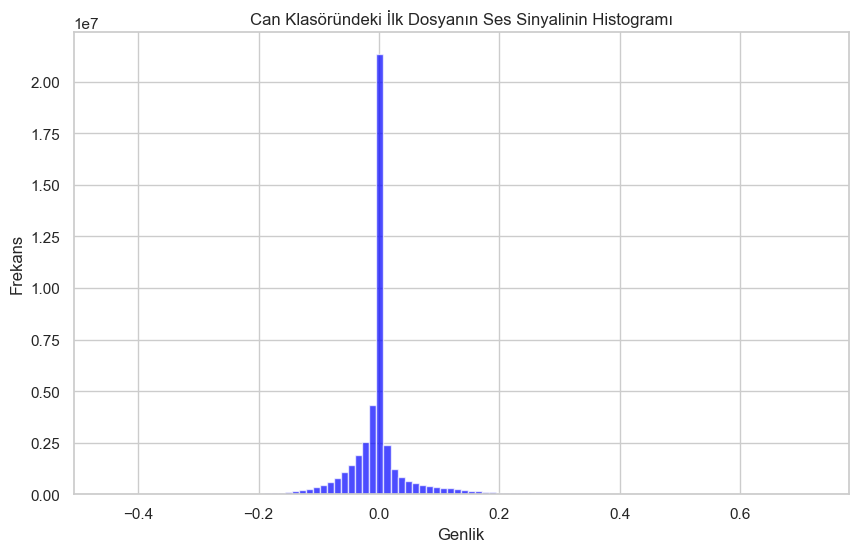

Processing first file in Ozlem: C:/Users/moonm/OneDrive/Masaüstü/seslerimiz/karışıkLüks/Ozlem\ozlem.wav


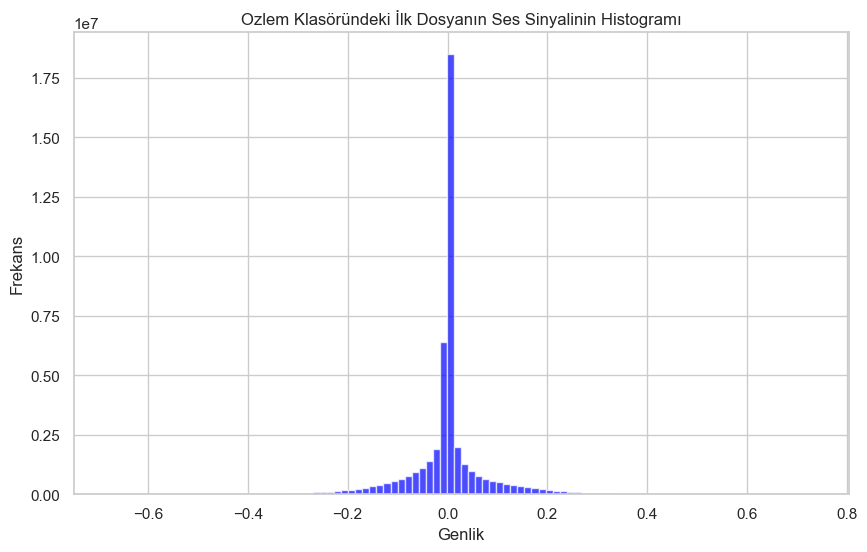

In [1]:
warnings.filterwarnings("ignore")

base_directory = "./voices/"
subdirectories = ["Ahmet", "Ali", "Can", "Ozlem"]

# Extracting features
def extract_features(audio_data, sr):
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)
    zcr = librosa.feature.zero_crossing_rate(y=audio_data)
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio_data), sr=sr)
    
    features = np.concatenate((np.mean(mfccs.T, axis=0), 
                               np.mean(zcr.T, axis=0), 
                               np.mean(chroma.T, axis=0),
                               np.mean(spectral_contrast.T, axis=0),
                               np.mean(tonnetz.T, axis=0)))
    return features

#Appending files and labels
X = []
Y = []
for subdirectory in subdirectories:
    audio_directory = os.path.join(base_directory, subdirectory)
    for root, _, files in os.walk(audio_directory):
        for filename in files:
            if filename.endswith(".wav"):  # files with .wav extension
                file_path = os.path.join(root, filename)
                X.append(file_path)
                label = os.path.splitext(filename)[0].split('_')[0]  # take file name as label
                Y.append(label)

#check number of file and label
print(f"Yüklenen dosya sayısı: {len(X)}")
print(f"Yüklenen etiket sayısı: {len(Y)}")

# Extracting MFCC features
mfcc_features = []
for file in X:
    try:
        audio_data, sr = librosa.load(file, sr=22050)
        audio_data = librosa.util.normalize(audio_data)  # normalization of voice data
        mfcc_features.append(extract_features(audio_data, sr))  # extracting features
    except Exception as e:
        print(f"Error processing {file}: {e}")

mfcc_features = np.array(mfcc_features)

# MFCC features number
print(f"MFCC özellik sayısı: {len(mfcc_features)}")

# Train test split
if len(mfcc_features) > 0 and len(Y) > 0:
    X_train, X_test, Y_train, Y_test = train_test_split(mfcc_features, Y, test_size=0.2, random_state=42)

    # Model optimization parameters
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                               param_grid=param_grid, 
                               cv=5, 
                               n_jobs=-1, 
                               verbose=2)

    grid_search.fit(X_train, Y_train)
    best_model = grid_search.best_estimator_

    # Save model
    joblib.dump(best_model, "VoiceRecognitionModel.pkl")

    # Modeli test etme
    Y_pred = best_model.predict(X_test)
    print("Accuracy:", accuracy_score(Y_test, Y_pred))
    print("F1 Score:", f1_score(Y_test, Y_pred, average='weighted'))
    print("Classification Report:\n", classification_report(Y_test, Y_pred))

    # prediction from voice data
    def predict_single_file(file_path, model):
        try:
            audio_data, sr = librosa.load(file_path, sr=22050)
            audio_data = librosa.util.normalize(audio_data)
            features = extract_features(audio_data, sr)
            features = features.reshape(1, -1)  # Reshape
            prediction = model.predict(features)
            return prediction[0]
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            return None

    # Plot a histogram of the prediction results and the audio signal of the first audio files on each folder
    sns.set(style="whitegrid")
    for subdirectory in subdirectories:
        audio_directory = os.path.join(base_directory, subdirectory)
        first_file_path = None
        for root, _, files in os.walk(audio_directory):
            for filename in files:
                if filename.endswith(".wav"):  
                    first_file_path = os.path.join(root, filename)
                    break
            if first_file_path:
                break

        if first_file_path:
            print(f"Processing first file in {subdirectory}: {first_file_path}")
            try:
                audio_data, sr = librosa.load(first_file_path, sr=None)
                plt.figure(figsize=(10, 6))
                plt.hist(audio_data, bins=100, color='blue', alpha=0.7)
                plt.xlabel('Genlik')
                plt.ylabel('Frekans')
                plt.title(f"{subdirectory} Klasöründeki İlk Dosyanın Ses Sinyalinin Histogramı")
                plt.grid(True)
                plt.show()
            except Exception as e:
                print(f"Error loading {first_file_path}: {e}")
else:
    print("MFCC özellikleri çıkarılamadı veya ses dosyaları yüklenemedi.")


In [2]:
# prediction from specific voice file
def predict_specific_file(file_path, model):
    try:
        prediction = predict_single_file(file_path, model)
        print("Predicted Label:", prediction)
    except Exception as e:
        print(f"Error predicting {file_path}: {e}")

# Örnek olarak Ahmet_000.wav dosyasını tahmin et
predict_specific_file("./Ali/ali_01.wav", best_model)

Predicted Label: ali


In [3]:
# Settings for audio recording and real-time prediction
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 22050
CHUNK = 1024
RECORD_SECONDS = 3
WAVE_OUTPUT_FILENAME = "output.wav"

# real time record
def record_audio():
    audio = pyaudio.PyAudio()
    stream = audio.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)
    frames = []

    print("Recording...")
    for _ in range(int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    print("Recording finished.")

    stream.stop_stream()
    stream.close()
    audio.terminate()

    waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    waveFile.setnchannels(CHANNELS)
    waveFile.setsampwidth(audio.get_sample_size(FORMAT))
    waveFile.setframerate(RATE)
    waveFile.writeframes(b''.join(frames))
    waveFile.close()

# Speech recognition
def recognize_speech(file_path):
    recognizer = sr.Recognizer()
    audio_file = sr.AudioFile(file_path)
    with audio_file as source:
        audio_data = recognizer.record(source)
    try:
        text = recognizer.recognize_google(audio_data, language='tr-TR')
        #print(f"Recognized Text: {text}")
        return text
    except sr.UnknownValueError:
        print("Google Speech Recognition could not understand audio")
        return None
    except sr.RequestError as e:
        print(f"Could not request results from Google Speech Recognition service; {e}")
        return None

# Extracting features
def extract_features(audio_data, sr):
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)
    zcr = librosa.feature.zero_crossing_rate(y=audio_data)
    chroma = librosa.feature.chroma_stft(y=audio_data, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio_data), sr=sr)
    
    features = np.concatenate((np.mean(mfccs.T, axis=0), 
                               np.mean(zcr.T, axis=0), 
                               np.mean(chroma.T, axis=0),
                               np.mean(spectral_contrast.T, axis=0),
                               np.mean(tonnetz.T, axis=0)))
    return features

# prediction from voice files
def predict_single_file(file_path, model):
    try:
        audio_data, sr = librosa.load(file_path, sr=22050)
        audio_data = librosa.util.normalize(audio_data)
        features = extract_features(audio_data, sr)
        features = features.reshape(1, -1)  # Reshape
        prediction = model.predict(features)
        return prediction[0]
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Prediction and speech recognition using recorded audio file
def predict_and_recognize(model):
    record_audio()
    predicted_label = predict_single_file(WAVE_OUTPUT_FILENAME, model)
    recognized_text = recognize_speech(WAVE_OUTPUT_FILENAME)
    
    if recognized_text:
        print(f"Predicted Label: {predicted_label}")
        print(f"Recognized Speech: {recognized_text}")
    else:
        print("No speech recognized.")

# Loading model
model = joblib.load("VoiceRecognitionModel.pkl")

# Prediction and speech recognition in an infinite loop
while True:
    predict_and_recognize(model)
    print("Waiting for the next recording...")
    time.sleep(1)  # wait for 2 second before next record

Recording...
Recording finished.
Google Speech Recognition could not understand audio
No speech recognized.
Waiting for the next recording...
Recording...
Recording finished.
Google Speech Recognition could not understand audio
No speech recognized.
Waiting for the next recording...
Recording...
Recording finished.
Google Speech Recognition could not understand audio
No speech recognized.
Waiting for the next recording...
Recording...
Recording finished.
Predicted Label: melih
Recognized Speech: Merhaba ben Ahmet 21
Waiting for the next recording...
Recording...
Recording finished.
Predicted Label: melih
Recognized Speech: İstanbul'da oturuyorum
Waiting for the next recording...
Recording...
Recording finished.
Predicted Label: melih
Recognized Speech: Normalde demiyorum
Waiting for the next recording...
Recording...
Recording finished.
Google Speech Recognition could not understand audio
No speech recognized.
Waiting for the next recording...
Recording...
Recording finished.
Google Sp

KeyboardInterrupt: 